# Bayesian A/B Testing

In [1]:
%load_ext autoreload
%autoreload 2
from scipy import integrate
import scipy.special as special
from scipy.stats import beta,chi2_contingency,gaussian_kde,rv_continuous,norm,rv_histogram
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd 
import numpy as np
import numpy.typing as npt
import matplotlib.cm as cm
import seaborn as sns
import quadpy
df = pd.read_csv('fbrefshootingdata.csv', encoding='utf-8-sig')
df = df[(df.npG >= 1) & (df.Shots >= 10)].reset_index(drop=True)
df['Conv'] = df['npG']/df['Shots']
bf = beta.fit(df['Conv'], floc=0, fscale=1)
df['Eb_Conv'] = (df['npG']+bf[0])/(df['Shots']+bf[0]+bf[1])
df['a'] = df['npG'] + bf[0]
df['b'] = df['Shots'] + bf[1] - df['npG']

We will use A/B testing to answer the burning question that haunts us in our dreams : is Messi better than Ronaldo ? Let's use multiple methods to destroy Ronnie boy.

In [2]:
messi = df[df.Player.str.contains('Lionel Messi')]
ronaldo = df[df.Player.str.contains('Cristiano Ronaldo')]

Method 1 : Simulations. We will use the posterior distributions for each player to draw many many possible conversion rate values and check in how many of them Messi beats Ronaldo.

In [3]:
messi_r = beta.rvs(messi.a, messi.b, size=100000)
ronaldo_r = beta.rvs(ronaldo.a, ronaldo.b, size=100000)
simulation = np.mean(messi_r > ronaldo_r)
print(f"Probability that Messi is better at shot conversion than Ronaldo is {round(simulation*100)} %")

Probability that Messi is better at shot conversion than Ronaldo is 98 %


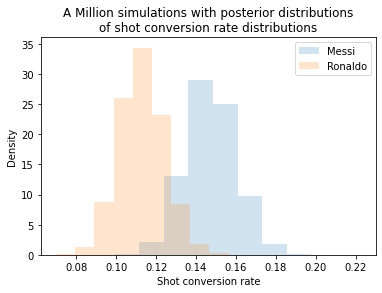

In [4]:
fig, ax = plt.subplots()
ax.hist(messi_r, density=True, histtype='stepfilled', alpha=0.2, label = 'Messi');
ax.hist(ronaldo_r, density=True, histtype='stepfilled', alpha=0.2, label = 'Ronaldo');
ax.legend();
ax.set_xlabel('Shot conversion rate');
ax.set_ylabel('Density');
ax.set_title('A Million simulations with posterior distributions'+'\n'+
            'of shot conversion rate distributions');

Method 2 : Exact formula for Beta distributions. Suppose you have the two distributions as $ p_A \sim Beta(\alpha_A, \beta_A) $ and $ p_B \sim Beta(\alpha_B, \beta_B) $ Then, the probability that $p_B > p_A $ is given by 

$$
    Pr(p_B > p_A) = \sum_{i=0}^{\alpha_B - 1} \frac{B(\alpha_A + i, \beta_A + \beta_B)}{(\beta_B + i) B(1+i, \beta_B) B(\alpha_A, \beta_A)}
$$

where B is the Beta function.

In [5]:
def func(a1,b1,a2,b2):
    ii = np.arange(0, int(round(a2)))
    logvals = special.betaln(a1+ii,b1+b2) - np.log(b2 + ii) - special.betaln(1+ii,b2) - special.betaln(a1,b1)
    return round(np.sum(np.exp(logvals))*100)

prob = func(ronaldo.a.values.item(), ronaldo.b.values.item(), messi.a.values.item(), messi.b.values.item() )
print(f"Probability that Messi is better at shot conversion than Ronaldo is {prob} %")

Probability that Messi is better at shot conversion than Ronaldo is 98 %


$\chi^2$ test 

In [6]:
data = [[messi.npG.values.item(), messi.Shots.values.item()-messi.npG.values.item()],
        [ronaldo.npG.values.item(), ronaldo.Shots.values.item() - ronaldo.npG.values.item()]]
stat, p, dof, expected = chi2_contingency(data)
  
# interpret p-value
alpha = 0.05
print("p value is " + str(p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (H0 holds true)')

p value is 0.0460006613899868
Dependent (reject H0)


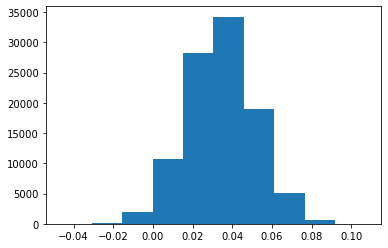

In [7]:
plt.hist(messi_r - ronaldo_r);

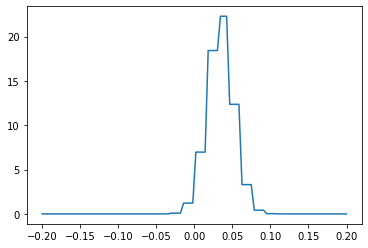

In [8]:
hist = np.histogram(messi_r - ronaldo_r)
hist_dist = rv_histogram(hist)
plt.plot(np.linspace(-0.2,0.2,100), hist_dist.pdf(np.linspace(-0.2,.2,100)));

In [9]:
hist_dist.ppf([0.25, 0.975])  ### 95 % credible interval

array([0.02182903, 0.07111545])